
# 📒 Escape Artist Agent — Analysis Notebook

This notebook **generate and preview figures** for the README using the artifacts saved under `runs/`.

It covers:
1. **Combined learning curves** for multiple runs (MC / MC-OFF / Q).  
2. **Value heatmap + greedy policy arrows** and a **greedy rollout** overlay on a fixed layout.  
3. **Ablations CSV** quick view (if you ran `experiments/ablations.py`).  
4. Show the **layout montage** image.

> Tip: Run the training first using the CLI or `make train-medium`, then come back here for deeper-dive.


In [18]:
# Bootstrap: ensure we're at the repo root and the package is installed in THIS kernel
import os
from pathlib import Path
import sys

# If we opened the notebook from experiments/, go up to repo root
if not (Path.cwd() / "pyproject.toml").exists() and (Path.cwd().name == "experiments"):
    os.chdir("..")

print("CWD:", Path.cwd())

# Install/editable into THIS kernel's interpreter
import sys
print("Python:", sys.executable)
%pip install -e .[dev]

# Sanity check import
import escape_artist
print("escape_artist from:", escape_artist.__file__)


CWD: /Users/jsong/workspace/Projects/escape-artist-agent
Python: /Users/jsong/opt/anaconda3/envs/escape-agent/bin/python
zsh:1: no matches found: .[dev]
Note: you may need to restart the kernel to use updated packages.
escape_artist from: /Users/jsong/workspace/Projects/escape-artist-agent/escape_artist/__init__.py


In [3]:

from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Project imports (assumes you're running this from the repo root)
from escape_artist.envs.escape_env import EscapeEnv, EnvConfig
from escape_artist.utils.plotting import (
    plot_learning_curve,
    plot_value_heatmap_and_policy,
    plot_greedy_rollout,
)

# Utility: load returns from a run dir
def load_returns(run_dir: Path) -> np.ndarray:
    p = run_dir / "returns.npy"
    if not p.exists():
        raise FileNotFoundError(f"Missing {p}")
    return np.load(p)

def ensure_dir(p: Path) -> Path:
    p.mkdir(parents=True, exist_ok=True)
    return p



## 1) Combined learning curves

Update the `runs` and `labels` lists to point at your training folders.

We show:
1) Raw episodic returns (quick look).
2) **Smoothed overlay** (200-ep moving average, no staggering) with a dashed **rolling success rate** (goal ≈ return > 0.0).

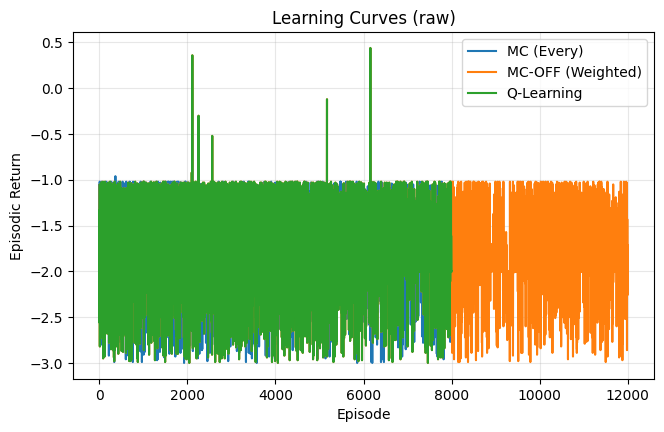

Saved: assets/figs/curve_medium_mc_mc-off_q.png
Also saved (compat): assets/curve_medium_mc_mc-off_q.png


In [20]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from shutil import copyfile

# --- Edit: for actual run folders ---
runs   = [Path("runs/mc_every_medium"), Path("runs/mc_off_weighted_medium"), Path("runs/q_medium")]
labels = ["MC (Every)", "MC-OFF (Weighted)", "Q-Learning"]

# Helper: load returns (works whether you have load_returns() defined or not)
def _load_returns_compat(run: Path) -> np.ndarray:
    try:
        # If your notebook defines load_returns(run), use it
        return load_returns(run)  # noqa: F821  (ignored if function exists)
    except NameError:
        # Fallback: directly load returns.npy
        return np.load(run / "returns.npy")

# ----------------- (A) Quick raw plot (kept from your original) -----------------
plt.figure(figsize=(7.5, 4.5))
for run, label in zip(runs, labels):
    r = _load_returns_compat(run)
    xs = np.arange(1, len(r) + 1)
    plt.plot(xs, r, label=label)
plt.xlabel("Episode")
plt.ylabel("Episodic Return")
plt.title("Learning Curves (raw)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# ----------------- (B) Smoothed overlay (+ rolling success rate) -----------------
from escape_artist.utils.plotting import plot_learning_curves_overlay, _ensure_dir  # _ensure_dir used below

# Build mapping: method -> returns
curves = {}
for run, label in zip(runs, labels):
    curves[label] = _load_returns_compat(run)

# Generate improved figure (saves to assets/figs/curve_medium_mc_mc-off_q.png)
out_dir = Path("assets")
_ensure_dir(out_dir)
fig_path = plot_learning_curves_overlay(
    method_returns=curves,
    out_dir=out_dir,
    window=200,                     # smoothing window
    also_success=True,              # dashed rolling success rate on twin y-axis
    title="Learning Curves (Medium, smoothed)",
    filename="curve_medium_mc_mc-off_q.png",
    success_threshold=0.0           # >0.0 ≈ reached goal in this env
)

# Also copy to assets/ (root) for backward-compatibility with older README links
src = Path("assets/figs/curve_medium_mc_mc-off_q.png")
dst = Path("assets/curve_medium_mc_mc-off_q.png")
dst.parent.mkdir(parents=True, exist_ok=True)
if src.exists():
    copyfile(src, dst)
    print(f"Saved: {src}")
    print(f"Also saved (compat): {dst}")
else:
    print("WARNING: Expected figure not found at", src)



# # Plot inline
# plt.figure(figsize=(7.5, 4.5))
# for run, label in zip(runs, labels):
#     r = load_returns(run)
#     xs = np.arange(1, len(r) + 1)
#     plt.plot(xs, r, label=label)
# plt.xlabel("Episode")
# plt.ylabel("Episodic Return")
# plt.title("Learning Curves")
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.show()

# # Also save a copy under assets/
# out_path = Path("assets/curve_medium_mc_mc-off_q.png")
# ensure_dir(out_path.parent)
# plt.figure(figsize=(7.5, 4.5))
# for run, label in zip(runs, labels):
#     r = load_returns(run)
#     xs = np.arange(1, len(r) + 1)
#     plt.plot(xs, r, label=label)
# plt.xlabel("Episode")
# plt.ylabel("Episodic Return")
# plt.title("Learning Curves")
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.savefig(out_path, bbox_inches="tight", dpi=150)
# print(f"Saved: {out_path}")


### Offline greedy evaluation (policy performance)

We evaluate the **current Q** *greedily* (ε=0) on **fresh randomized layouts** at one or more checkpoints,
plotting **Success Rate vs. training episode**. This shows *true policy quality* (separate from noisy behavior returns).


[MC (Every)] ep=12000  SR=0.220  (Q.npy)
[MC-OFF (Weighted)] ep=18000  SR=0.210  (Q.npy)
[Q-Learning] ep=12000  SR=0.220  (Q.npy)


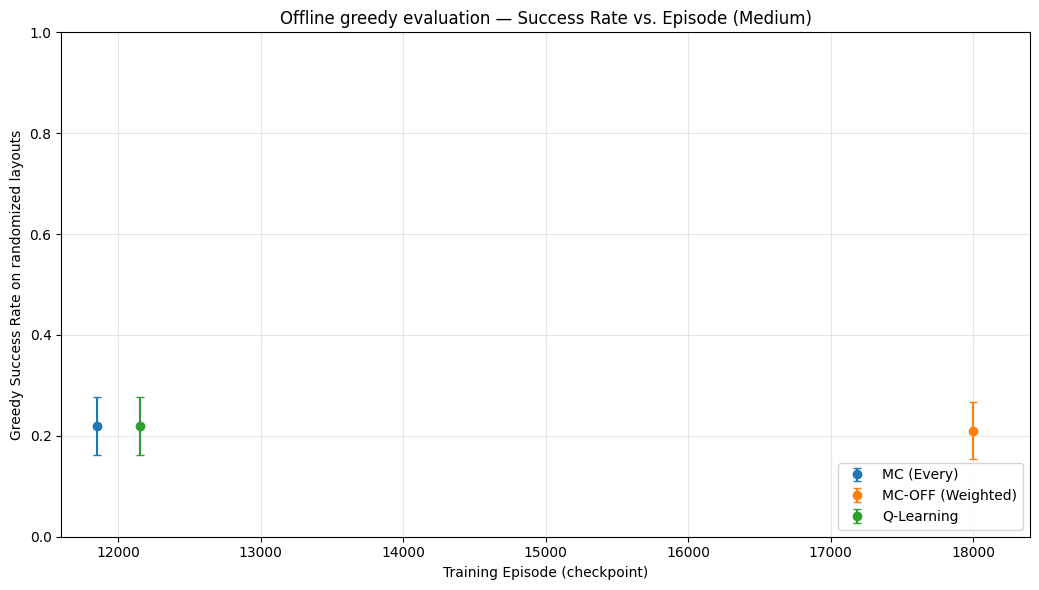


Summary (N_LAYOUTS = 200):
  MC (Every)         ep=12000  SR=0.220
  MC-OFF (Weighted)  ep=18000  SR=0.210
  Q-Learning         ep=12000  SR=0.220

Saved: assets/figs/curve_medium_offline_eval.png and assets/curve_medium_offline_eval.png


In [28]:
from pathlib import Path
import re, yaml, numpy as np
import matplotlib.pyplot as plt
from shutil import copyfile

from escape_artist.envs.escape_env import EscapeEnv, EnvConfig
from escape_artist.algos.mc_control import greedy_policy_rollout

# ----------------- Settings -----------------
CONFIG_PATH = Path("configs/medium.yaml")   # must match your Medium eval config
RUNS   = [
    Path("runs/mc_every_medium_long"),
    Path("runs/mc_off_weighted_medium_long"),
    Path("runs/q_medium_long"),
]
LABELS = ["MC (Every)", "MC-OFF (Weighted)", "Q-Learning"]

N_LAYOUTS = 200         # more layouts => tighter confidence intervals
SEED_BASE = 12345       # base RNG seed for eval sampling
OUT_PATH  = Path("assets/figs/curve_medium_offline_eval.png")

# Detect episode numbers from filenames like Q_ep12000.npy
CKPT_REGEX = re.compile(r"Q(?:_ep)?(\d+)\.npy$")

# ----------------- Helpers -----------------
def load_env_cfg(config_path: Path) -> dict:
    with open(config_path, "r") as f:
        return yaml.safe_load(f)["env"]

def make_env(env_cfg: dict, seed: int) -> EscapeEnv:
    cfg = EnvConfig(
        size=tuple(env_cfg.get("size", (10,10))),
        start=tuple(env_cfg.get("start", (0,0))),
        goal=tuple(env_cfg.get("goal", (9,9))),
        traps_pct=float(env_cfg.get("traps_pct", 0.10)),
        r_safe=int(env_cfg.get("r_safe", 1)),
        slip=float(env_cfg.get("slip", 0.10)),
        lethal_traps=bool(env_cfg.get("lethal_traps", True)),
        step_cost=float(env_cfg.get("step_cost", -0.01)),
        trap_penalty=float(env_cfg.get("trap_penalty", -1.0)),
        goal_reward=float(env_cfg.get("goal_reward", 1.0)),
        max_steps=int(env_cfg.get("max_steps", 200)),
        layout_mode="per_episode",     # randomized layouts for generalization
        seed=seed,
        obs_mode=str(env_cfg.get("obs_mode", "pos")),
    )
    return EscapeEnv(cfg)

def success_by_goal(env: EscapeEnv, traj) -> bool:
    # Robust success: last position equals goal tile
    return tuple(traj[-1]) == tuple(env.cfg.goal)

def eval_success_rate(Q: np.ndarray, env_cfg: dict, n_layouts: int, seed: int) -> float:
    rng = np.random.default_rng(seed)
    succ = 0
    for _ in range(n_layouts):
        env = make_env(env_cfg, int(rng.integers(1_000_000)))
        G, traj = greedy_policy_rollout(env, Q, max_steps=env.cfg.max_steps)
        succ += success_by_goal(env, traj)
    return succ / float(n_layouts)

def find_checkpoints(run_dir: Path) -> list[tuple[int, Path]]:
    """
    Returns sorted list of (episode, path) checkpoints.
    Prefers Q_epXXXX.npy files; falls back to final Q.npy (episode inferred from returns.npy length if present).
    """
    cands = []
    for p in run_dir.glob("Q_ep*.npy"):
        m = CKPT_REGEX.search(p.name)
        if m:
            cands.append((int(m.group(1)), p))

    if not cands:
        final_q = run_dir / "Q.npy"
        if final_q.exists():
            ret_path = run_dir / "returns.npy"
            final_ep = int(np.load(ret_path).shape[0]) if ret_path.exists() else 0
            cands = [(final_ep, final_q)]

    cands.sort(key=lambda t: t[0])
    return cands

# ----------------- Compute per-method SR vs episode -----------------
env_cfg = load_env_cfg(CONFIG_PATH)

series = {}   # label -> (episodes, success_rates)
for label, run in zip(LABELS, RUNS):
    ckpts = find_checkpoints(run)
    if not ckpts:
        print(f"[WARN] No Q checkpoints found in {run}. Skipping {label}.")
        continue

    eps, srs = [], []
    for (ep, qpath) in ckpts:
        Q = np.load(qpath)
        sr = eval_success_rate(Q, env_cfg, n_layouts=N_LAYOUTS, seed=SEED_BASE + ep)
        eps.append(ep)
        srs.append(sr)
        print(f"[{label}] ep={ep:>5}  SR={sr:.3f}  ({qpath.name})")
    series[label] = (np.array(eps), np.array(srs))

# ----------------- Plot with jitter + 95% CI -----------------
# Small horizontal jitter so overlapping points are visible
def jitter_offsets(n):
    if n == 1: return [0]
    if n == 2: return [-150, +150]
    # 3+ → symmetric jitter
    base = 150
    return [int((i - (n-1)/2) * base) for i in range(n)]

fig, ax = plt.subplots(figsize=(10.5, 6))
labels_in_series = list(series.keys())
jitters = dict(zip(labels_in_series, jitter_offsets(len(labels_in_series))))

for label in labels_in_series:
    eps, srs = series[label]
    order = np.argsort(eps)
    eps = eps[order]
    srs = srs[order]

    x = eps + jitters[label]
    N = max(1, N_LAYOUTS)
    se = np.sqrt(np.clip(srs * (1 - srs) / N, 0, 1))   # binomial standard error
    ax.errorbar(x, srs, yerr=1.96 * se, fmt="o", capsize=3, label=label, zorder=3)

# Axis cosmetics
if labels_in_series:
    all_eps = np.concatenate([series[k][0] for k in labels_in_series])
    ax.set_xlim(float(all_eps.min()) - 400, float(all_eps.max()) + 400)

ax.set_title("Offline greedy evaluation — Success Rate vs. Episode (Medium)")
ax.set_xlabel("Training Episode (checkpoint)")
ax.set_ylabel("Greedy Success Rate on randomized layouts")
ax.set_ylim(0.0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right")
fig.tight_layout()

OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(OUT_PATH, bbox_inches="tight", dpi=150)
plt.show()
copyfile(OUT_PATH, Path("assets/curve_medium_offline_eval.png"))

# Also print a tiny summary table for the notebook output
print("\nSummary (N_LAYOUTS = {}):".format(N_LAYOUTS))
for label in labels_in_series:
    eps, srs = series[label]
    for e, s in zip(eps, srs):
        print(f"  {label:18s} ep={int(e):5d}  SR={s:.3f}")
print(f"\nSaved: {OUT_PATH} and assets/curve_medium_offline_eval.png")



## 2) Fixed layout overlays (value heatmap + greedy rollout)

This cell creates a **fixed-layout** environment (so visuals are stable) using the **medium** config settings.  
Then it loads a `Q.npy` from one of your runs and generates two figures:

- `value_heatmap_policy.png` — value heatmap with greedy arrows  
- `greedy_rollout.png` — a single greedy trajectory overlay  


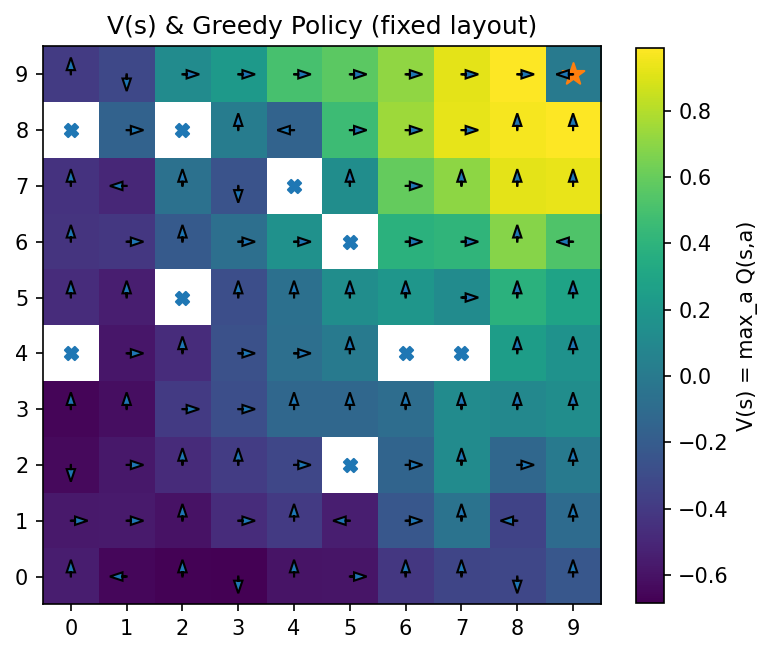

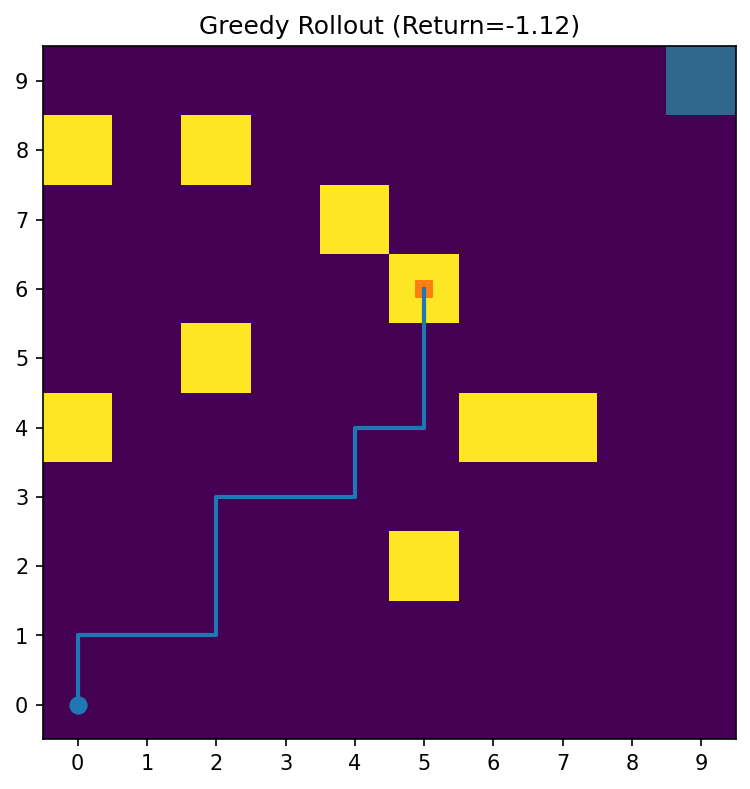

> /Users/jsong/opt/anaconda3/envs/escape-agent/bin/python -m experiments.make_hero_gif --run runs/q_medium_long --config configs/medium.yaml --want success --layout per_env --out assets/rollout_success.gif --fps 4
Saved GIF (success) at seed=130: assets/rollout_success.gif
> /Users/jsong/opt/anaconda3/envs/escape-agent/bin/python -m experiments.make_hero_gif --run runs/q_medium_long --config configs/medium.yaml --want failure --layout per_env --out assets/rollout_failed.gif --fps 4
Saved GIF (failure) at seed=123: assets/rollout_failed.gif


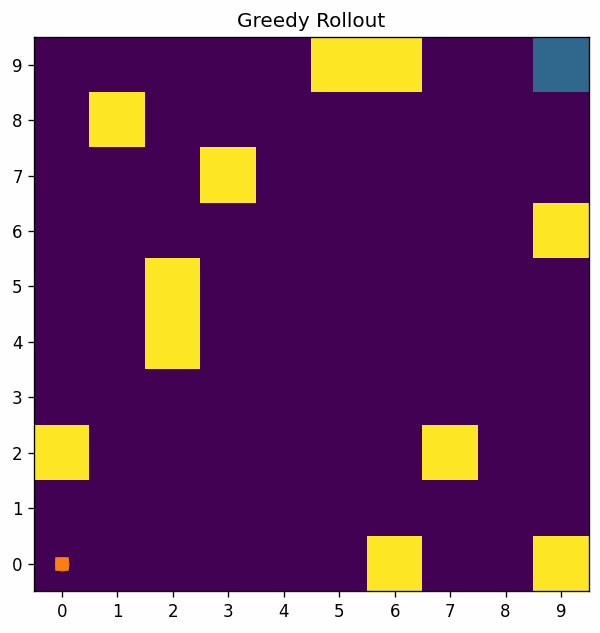

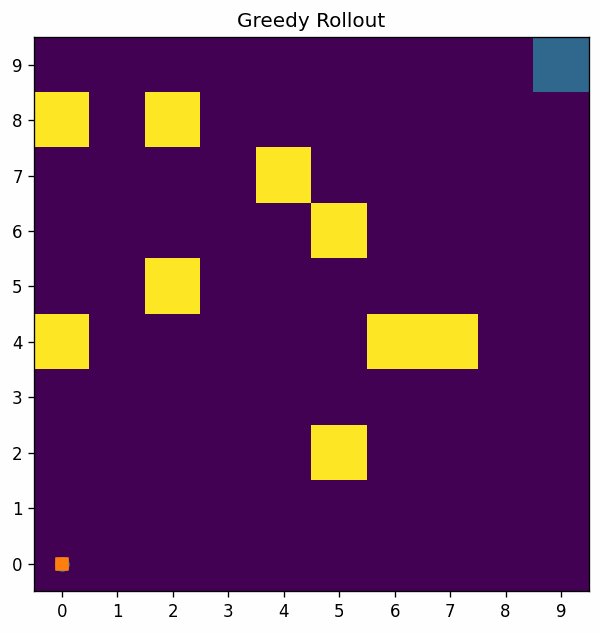

In [5]:

# import yaml

# # Load a config (use medium by default; change if you like)
# cfg_path = Path("configs/medium.yaml")
# if not cfg_path.exists():
#     # fall back to easy if medium not present
#     cfg_path = Path("configs/easy.yaml")
# print("Using config:", cfg_path)

# with open(cfg_path, "r") as f:
#     cfg_all = yaml.safe_load(f)
# env_kwargs = cfg_all.get("env", {})

# # Build EnvConfig similar to the CLI builder
# def tuple_or(v, default):
#     return tuple(v) if isinstance(v, (list, tuple)) else default

# size = tuple_or(env_kwargs.get("size", (10, 10)), (10, 10))
# start = tuple_or(env_kwargs.get("start", (0, 0)), (0, 0))
# goal = tuple_or(env_kwargs.get("goal", (size[1]-1, size[0]-1)), (size[1]-1, size[0]-1))

# env_cfg = EnvConfig(
#     size=size,
#     start=start,
#     goal=goal,
#     traps_pct=float(env_kwargs.get("traps_pct", 0.10)),
#     r_safe=int(env_kwargs.get("r_safe", 1)),
#     slip=float(env_kwargs.get("slip", 0.1)),
#     lethal_traps=bool(env_kwargs.get("lethal_traps", True)),
#     step_cost=float(env_kwargs.get("step_cost", -0.01)),
#     trap_penalty=float(env_kwargs.get("trap_penalty", -1.0)),
#     goal_reward=float(env_kwargs.get("goal_reward", 1.0)),
#     max_steps=int(env_kwargs.get("max_steps", 200)),
#     layout_mode="per_env",  # fixed layout for clean visuals
#     seed=env_kwargs.get("seed", 123),
#     obs_mode=str(env_kwargs.get("obs_mode", "pos")),
# )

# env = EscapeEnv(env_cfg)
# env.reset(seed=env.cfg.seed)

# # Choose a run to visualize (change as needed)
# run_for_Q = Path("runs/q_medium")  # e.g., q_medium or mc_off_weighted_medium
# Q_path = run_for_Q / "Q.npy"
# assert Q_path.exists(), f"Cannot find {Q_path}. Train first or change run_for_Q."
# Q = np.load(Q_path)

# # Generate figures to assets/
# assets_dir = ensure_dir(Path("assets"))
# plot_value_heatmap_and_policy(env, Q, assets_dir, title="V(s) & Greedy Policy (fixed layout)")
# from escape_artist.algos.mc_control import greedy_policy_rollout
# plot_greedy_rollout(env, Q, greedy_policy_rollout, assets_dir, max_steps=env.cfg.max_steps)


# Fixed layout overlays + animated rollouts (success & failure)

import yaml, subprocess, sys
from pathlib import Path
import numpy as np
from IPython.display import Image, display

from escape_artist.envs.escape_env import EscapeEnv, EnvConfig
from escape_artist.utils.plotting import (
    plot_value_heatmap_and_policy,
    plot_greedy_rollout,
)
from escape_artist.algos.mc_control import greedy_policy_rollout

# Load config (medium default)
cfg_path = Path("configs/medium.yaml")
with open(cfg_path, "r") as f:
    cfg_all = yaml.safe_load(f)
env_kwargs = cfg_all.get("env", {})

def tuple_or(v, default):
    return tuple(v) if isinstance(v, (list, tuple)) else default

size  = tuple_or(env_kwargs.get("size", (10,10)), (10,10))
start = tuple_or(env_kwargs.get("start", (0,0)), (0,0))
goal  = tuple_or(env_kwargs.get("goal", (size[1]-1, size[0]-1)), (size[1]-1, size[0]-1))

env_cfg = EnvConfig(
    size=size, start=start, goal=goal,
    traps_pct=float(env_kwargs.get("traps_pct", 0.10)),
    r_safe=int(env_kwargs.get("r_safe", 1)),
    slip=float(env_kwargs.get("slip", 0.1)),
    lethal_traps=bool(env_kwargs.get("lethal_traps", True)),
    step_cost=float(env_kwargs.get("step_cost", -0.01)),
    trap_penalty=float(env_kwargs.get("trap_penalty", -1.0)),
    goal_reward=float(env_kwargs.get("goal_reward", 1.0)),
    max_steps=int(env_kwargs.get("max_steps", 200)),
    layout_mode="per_env",   # fixed layout for clean visuals
    seed=env_kwargs.get("seed", 123),
    obs_mode=str(env_kwargs.get("obs_mode", "pos")),
)

env = EscapeEnv(env_cfg)
env.reset(seed=env.cfg.seed)

# Choose a run to visualize
run_for_Q = Path("runs/q_medium_long")   # change if needed
Q_path = run_for_Q / "Q.npy"
assert Q_path.exists(), f"Cannot find {Q_path}. Train first or change run_for_Q."
Q = np.load(Q_path)

# 1) Static figures (saved under assets/figs)
assets_dir = Path("assets"); (assets_dir / "figs").mkdir(parents=True, exist_ok=True)
plot_value_heatmap_and_policy(env, Q, assets_dir, title="V(s) & Greedy Policy (fixed layout)")
plot_greedy_rollout(env, Q, greedy_policy_rollout, assets_dir, max_steps=env.cfg.max_steps)
display(Image(filename=str(assets_dir / "figs" / "value_heatmap_policy.png"), width=420))
display(Image(filename=str(assets_dir / "figs" / "greedy_rollout.png"), width=420))

# 2) Animated GIFs via updated make_hero_gif.py
def run(cmd):
    print(">", " ".join(map(str, cmd)))
    subprocess.run(cmd, check=True)

# success GIF
run([
    sys.executable, "-m", "experiments.make_hero_gif",
    "--run", str(run_for_Q),
    "--config", str(cfg_path),
    "--want", "success",
    "--layout", "per_env",
    "--out", "assets/rollout_success.gif",
    "--fps", "4",
])

# failure GIF
run([
    sys.executable, "-m", "experiments.make_hero_gif",
    "--run", str(run_for_Q),
    "--config", str(cfg_path),
    "--want", "failure",
    "--layout", "per_env",
    "--out", "assets/rollout_failed.gif",
    "--fps", "4",
])

display(Image(filename="assets/rollout_success.gif", width=360))
display(Image(filename="assets/rollout_failed.gif",  width=360))



# display(Image(filename=str(assets_dir / "figs" / "value_heatmap_policy.png"), width=420))
# display(Image(filename=str(assets_dir / "figs" / "greedy_rollout.png"), width=420))



## 3) Ablations quick view (if available)

If you ran `python -m experiments.ablations` (or used a Makefile target), this section will:

- Load `assets/ablations_mc_q.csv`  
- Show the first few rows  
- Render simple heatmaps for success rates (MC Every-Visit & Q-Learning)


,size,slip,traps_pct,algo,success_rate,avg_return
0,10x10,0.0,0.05,MC-every,0.566667,-0.010000
1,10x10,0.0,0.05,Q-learning,0.500000,-0.138667
2,10x10,0.0,0.10,MC-every,0.000000,-2.000000
3,10x10,0.0,0.10,Q-learning,0.000000,-2.000000
4,10x10,0.0,0.15,MC-every,0.000000,-2.000000


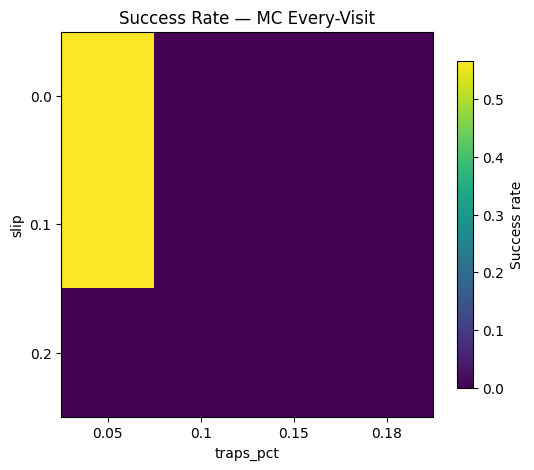

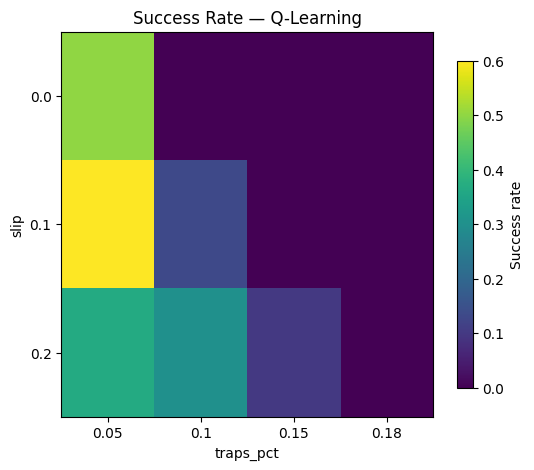

In [10]:

import pandas as pd

csv_path = Path("assets/ablations_mc_q.csv")
if not csv_path.exists():
    print("No ablations CSV found. Run: python -m experiments.ablations")
else:
    df = pd.read_csv(csv_path)
    display(df.head())

    # Pivot success matrices
    def pivot_success(df_algo):
        # rows = slip, cols = traps_pct
        piv = df_algo.pivot_table(index="slip", columns="traps_pct", values="success_rate", aggfunc="mean")
        return piv.sort_index(axis=0).sort_index(axis=1)

    df_mc = df[df["algo"] == "MC-every"]
    df_q  = df[df["algo"] == "Q-learning"]
    piv_mc = pivot_success(df_mc)
    piv_q  = pivot_success(df_q)

    # Plot each heatmap
    for name, piv in [("MC Every-Visit", piv_mc), ("Q-Learning", piv_q)]:
        plt.figure(figsize=(6, 5))
        plt.imshow(piv.values, origin="upper", aspect="auto")
        plt.colorbar(shrink=0.85, label="Success rate")
        plt.xticks(range(len(piv.columns)), [str(c) for c in piv.columns])
        plt.yticks(range(len(piv.index)), [str(i) for i in piv.index])
        plt.xlabel("traps_pct")
        plt.ylabel("slip")
        plt.title(f"Success Rate — {name}")
        plt.show()



## 4) Layout montage

If you created the montage with `python -m experiments.make_layout_montage`, display it below.


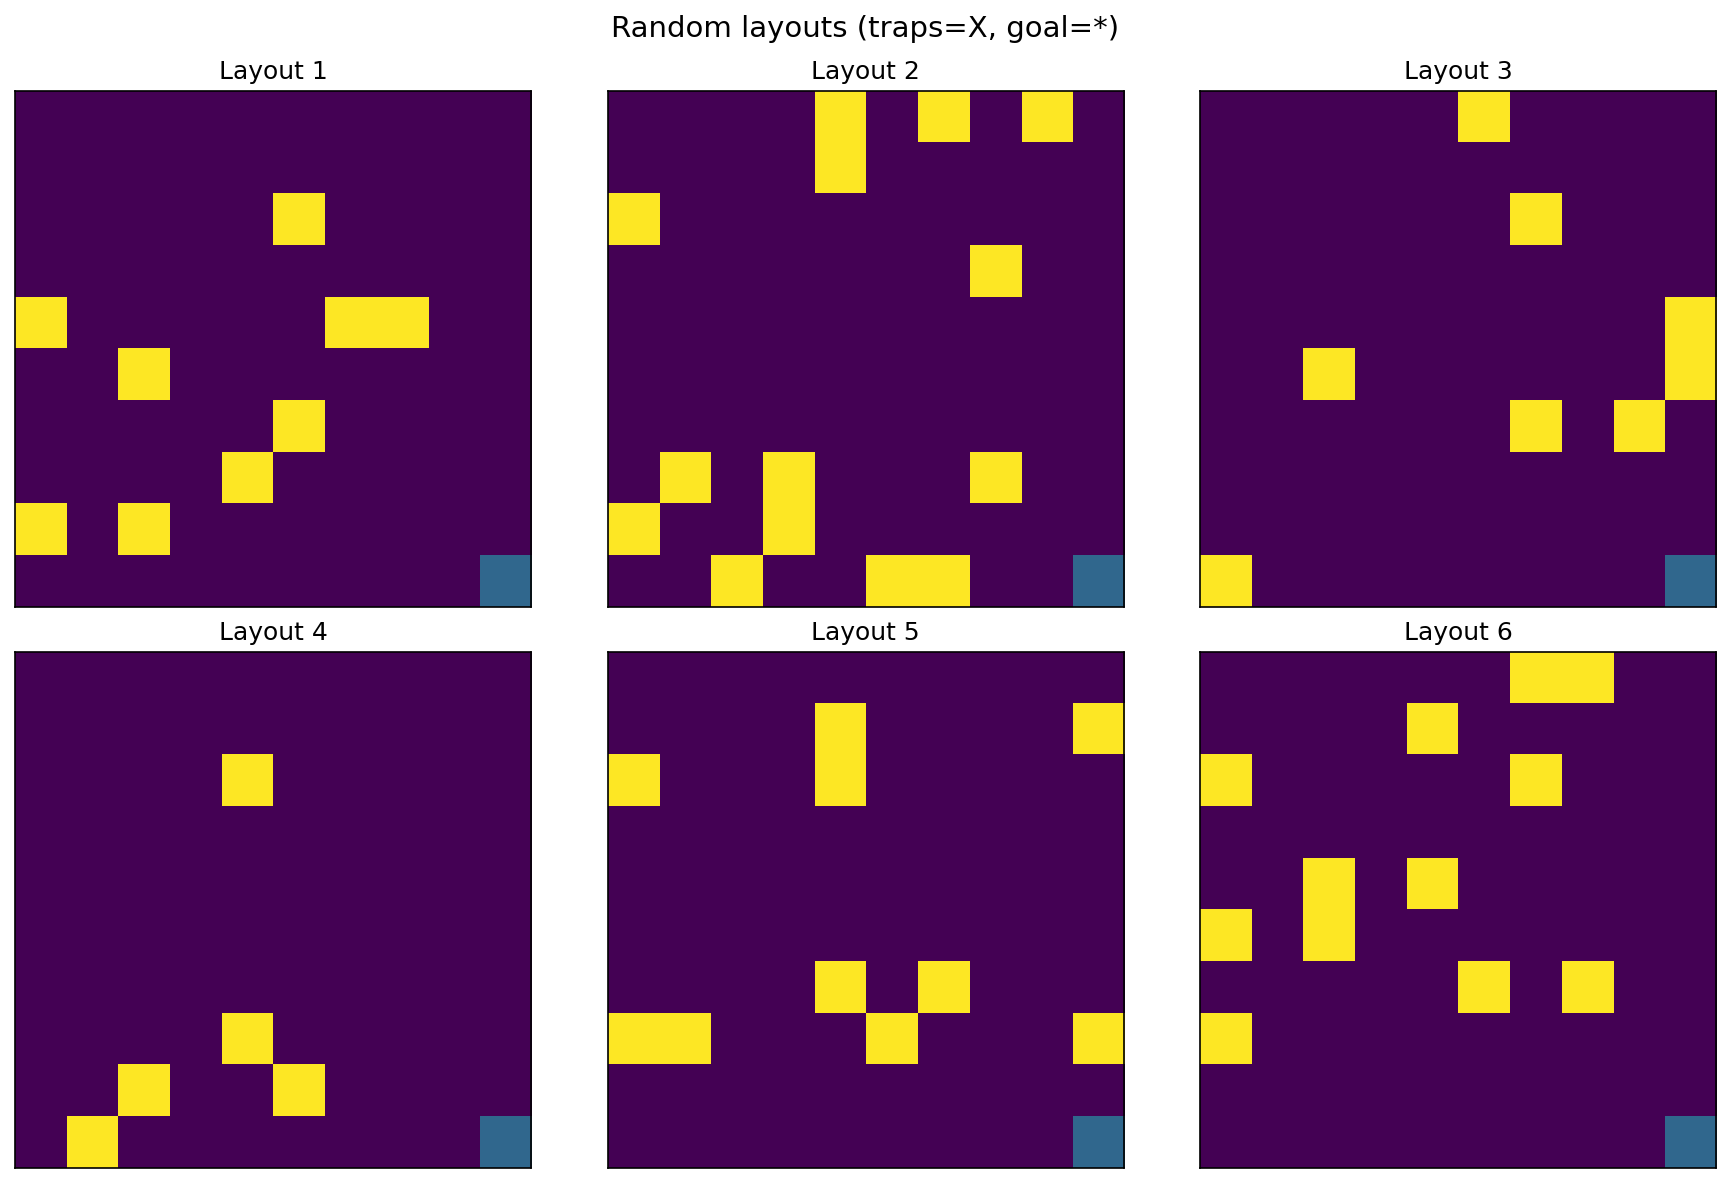

In [11]:

montage_path = Path("assets/layout_montage.png")
if montage_path.exists():
    display(Image(filename=str(montage_path), width=720))
else:
    print("No montage found. Run: python -m experiments.make_layout_montage --out assets/layout_montage.png")


## 5) Policy behavior by algorithm (same fixed layout)

We search for a **single fixed map** (using `layout_mode="per_env"`) that **all methods** solve, then render
three GIFs—one per algorithm—on that **exact same layout**. This makes behavior differences comparable and fair.

*Requirements:* trained runs with `Q.npy` (e.g., `runs/mc_every_medium_long`, `runs/mc_off_weighted_medium_long`, `runs/q_medium_long`)
and the updated `experiments.make_hero_gif` that supports rollout mode (`--run`, `--config`, `--layout`, `--seed`, `--want`).


In [11]:
# Params
MC_E   = "runs/mc_every_medium_long"
MC_OFF = "runs/mc_off_weighted_medium_long"
QL     = "runs/q_medium_long"
CONFIG = "configs/medium.yaml"

SEED_START, SEED_END = 100, 400   # search range for a shared-success fixed layout
GIF_FPS = 4
OUTPUT_DIR = "assets"

from pathlib import Path
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Optional: verify Q files exist (quick sanity)
for run in (MC_E, MC_OFF, QL):
    qpath = Path(run) / "Q.npy"
    print(("OK  " if qpath.exists() else "MISSING  ") + str(qpath))

OK  runs/mc_every_medium_long/Q.npy
OK  runs/mc_off_weighted_medium_long/Q.npy
OK  runs/q_medium_long/Q.npy


In [7]:
# Find a common success seed (same map for all; layout_mode=per_env)
import subprocess, sys

def makes_success_gif(run_dir: str, seed: int, tmp_out: str) -> bool:
    cmd = [
        sys.executable, "-m", "experiments.make_hero_gif",
        "--run", run_dir,
        "--config", CONFIG,
        "--layout", "per_env",     # fixed layout for fairness
        "--seed", str(seed),
        "--max_tries", "1",
        "--want", "success",
        "--out", tmp_out,
        "--fps", str(GIF_FPS),
    ]
    try:
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        return True
    except subprocess.CalledProcessError:
        return False

COMMON_SEED = None
for s in range(SEED_START, SEED_END + 1):
    if not makes_success_gif(MC_E, s, "/tmp/_mc_every.gif"):  continue
    if not makes_success_gif(MC_OFF, s, "/tmp/_mc_off.gif"):  continue
    if not makes_success_gif(QL, s, "/tmp/_q.gif"):           continue
    COMMON_SEED = s
    break

if COMMON_SEED is None:
    raise RuntimeError(
        f"No common success seed found in {SEED_START}..{SEED_END}. "
        "Widen the range or train longer / slow ε decay."
    )
print("Found common success seed:", COMMON_SEED)

Found common success seed: 109


In [12]:
# Render final comparison GIFs on that exact map and display side-by-side
import subprocess
from IPython.display import HTML, display

out_mc = f"{OUTPUT_DIR}/compare_mc_every.gif"
out_off = f"{OUTPUT_DIR}/compare_mc_off.gif"
out_q = f"{OUTPUT_DIR}/compare_q_learning.gif"

def render_final(run_dir: str, out_path: str):
    subprocess.run([
        sys.executable, "-m", "experiments.make_hero_gif",
        "--run", run_dir, "--config", CONFIG,
        "--layout", "per_env", "--seed", str(COMMON_SEED),
        "--max_tries", "1", "--want", "success",
        "--out", out_path, "--fps", str(GIF_FPS),
    ], check=True)

render_final(MC_E,   out_mc)
render_final(MC_OFF, out_off)
render_final(QL,     out_q)

html = f"""
<div style='display:flex; gap:12px; justify-content:center;'>
  <div style='text-align:center;'>
    <img src='{out_mc}' width='240'><br><div style='font-size:14px;'>MC (Every-Visit)</div>
  </div>
  <div style='text-align:center;'>
    <img src='{out_off}' width='240'><br><div style='font-size:14px;'>MC-OFF (Weighted IS)</div>
  </div>
  <div style='text-align:center;'>
    <img src='{out_q}' width='240'><br><div style='font-size:14px;'>Q-Learning</div>
  </div>
</div>
<p style='text-align:center; font-style:italic; margin-top:8px;'>
  Same map & seed (<code>per_env</code>); differences reflect policy behavior, not the layout.
</p>
"""
display(HTML(html))
print("Saved:\n ", out_mc, "\n ", out_off, "\n ", out_q)

Saved GIF (success) at seed=109: assets/compare_mc_every.gif
Saved GIF (success) at seed=109: assets/compare_mc_off.gif
Saved GIF (success) at seed=109: assets/compare_q_learning.gif


Saved:
  assets/compare_mc_every.gif 
  assets/compare_mc_off.gif 
  assets/compare_q_learning.gif


#### Diagnostics

In [13]:
# Diagnostics: quantify differences on the SAME fixed layout & seed
# Uses the same CONFIG, COMMON_SEED, and run dirs (MC_E, MC_OFF, QL) already set above.
import numpy as np
from pathlib import Path
from escape_artist.envs.escape_env import EscapeEnv, EnvConfig
from escape_artist.envs.generators import TRAP, GOAL
from escape_artist.algos.mc_control import greedy_policy_rollout
import yaml

def load_env_fixed(config_path, seed):
    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)["env"]
    # force fixed layout for fair comparison
    cfg["layout_mode"] = "per_env"
    cfg["seed"] = int(seed)
    return EscapeEnv(EnvConfig(
        size=tuple(cfg.get("size", (10,10))),
        start=tuple(cfg.get("start", (0,0))),
        goal=tuple(cfg.get("goal", (9,9))),
        traps_pct=float(cfg.get("traps_pct", 0.10)),
        r_safe=int(cfg.get("r_safe", 1)),
        slip=float(cfg.get("slip", 0.10)),
        lethal_traps=bool(cfg.get("lethal_traps", True)),
        step_cost=float(cfg.get("step_cost", -0.01)),
        trap_penalty=float(cfg.get("trap_penalty", -1.0)),
        goal_reward=float(cfg.get("goal_reward", 1.0)),
        max_steps=int(cfg.get("max_steps", 200)),
        layout_mode="per_env",
        seed=seed,
        obs_mode=str(cfg.get("obs_mode", "pos")),
    ))

def rollout_traj(env, Q_path):
    Q = np.load(Q_path)
    env.reset(seed=env.cfg.seed)
    G, traj = greedy_policy_rollout(env, Q, max_steps=env.cfg.max_steps)
    return G, traj

def manhattan(a,b): return abs(a[0]-b[0]) + abs(a[1]-b[1])

def min_trap_distance_along(traj, grid):
    traps = [(x,y) for y in range(grid.shape[0]) for x in range(grid.shape[1]) if grid[y,x]==TRAP]
    if not traps:
        return np.inf, 0.0
    dists = []
    near_cnt = 0
    for p in traj:
        d = min(manhattan(p,t) for t in traps)
        dists.append(d)
        if d <= 1: near_cnt += 1
    return float(min(dists)), near_cnt / max(1,len(traj))  # min clearance, fraction of steps within 1 cell of a trap

def backtrack_count(traj):
    # immediate reversals: ... -> A -> B -> A ...
    cnt = 0
    for i in range(1, len(traj)-1):
        if traj[i-1] == traj[i+1] != traj[i]:
            cnt += 1
    return cnt

def summarize(label, env, Q_path):
    G, traj = rollout_traj(env, Q_path)
    steps = len(traj) - 1
    success = (env.grid[traj[-1][1], traj[-1][0]] == GOAL)
    unique_visits = len(set(traj))
    revisit_rate = 1.0 - unique_visits/len(traj)
    min_clear, frac_near = min_trap_distance_along(traj, env.grid)
    backs = backtrack_count(traj)
    print(f"[{label}] success={success} | steps={steps} | return={G:.2f} | "
          f"min_trap_dist={min_clear:.1f} | near_trap%={frac_near*100:.1f}% | "
          f"backtracks={backs} | revisit_rate={revisit_rate*100:.1f}%")
    return {
        "label": label, "success": success, "steps": steps, "return": G,
        "min_trap_dist": min_clear, "near_trap_frac": frac_near,
        "backtracks": backs, "revisit_rate": revisit_rate,
    }

# Build the exact same map
env = load_env_fixed(CONFIG, COMMON_SEED)

# Summarize each method (FIXED: pass env as the 2nd arg)
rows = []
rows.append(summarize("MC (Every)", env, Path(MC_E) / "Q.npy"))
rows.append(summarize("MC-OFF (Weighted)", env, Path(MC_OFF) / "Q.npy"))
rows.append(summarize("Q-Learning", env, Path(QL) / "Q.npy"))


[MC (Every)] success=True | steps=18 | return=0.82 | min_trap_dist=1.0 | near_trap%=15.8% | backtracks=0 | revisit_rate=0.0%
[MC-OFF (Weighted)] success=True | steps=18 | return=0.82 | min_trap_dist=1.0 | near_trap%=10.5% | backtracks=0 | revisit_rate=0.0%
[Q-Learning] success=True | steps=18 | return=0.82 | min_trap_dist=1.0 | near_trap%=15.8% | backtracks=0 | revisit_rate=0.0%
